# Optically-dark short GRBs

## Imports/loading/setup

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib
from astropy.io import votable, ascii
from scipy import interpolate
from custom_utils import AsymmetricUncertainty, custom_iter

alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
numeric = ".0123456789"
calc_code = importlib.import_module("Calculation Code.main")
graph_code = importlib.import_module("Graphing Code.Graphing_Beta_OX")

In [2]:
swift = pd.read_html("https://swift.gsfc.nasa.gov/archive/grb_table/fullview/")[0] # get latest Swift catalog
swift.columns = [col[0] for col in swift.columns] # reduce MultiIndex
sGRBs = swift[swift["BAT T90[sec]"].apply(pd.to_numeric, errors="coerce") <= 2].copy() # filter catalog for GRBs with a valid T90 that is <2s

## Data parsing and cleanup

In [3]:
# format columns
sGRBs.drop(['Time[UT]', 'BAT RA(J2000)', 'BAT Dec(J2000)', 'BAT 90%Error Radius[arcmin]',
            'BAT Fluence(15-150 keV)[10-7 erg/cm2]', 'BAT Fluence90% Error(15-150 keV)[10-7 erg/cm2]',
            'BAT 1-sec PeakPhoton Flux(15-150 keV)[ph/cm2/sec]', 'BAT 1-sec PeakPhoton Flux90% Error(15-150 keV)[ph/cm2/sec]',
            'BAT Photon Index(15-150 keV)(PL = simple power-law,CPL = cutoff power-law)', 'BAT Photon Index90% Error(15-150 keV)',
            'XRT RA(J2000)', 'XRT Dec(J2000)', 'XRT 90%Error Radius[arcsec]', 'XRT Column Density(NH)[1021 cm-2]',
            'XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'XRT 11 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]',
            'XRT 24 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'UVOT RA(J2000)', 'UVOT Dec(J2000)', 'UVOT 90%Error Radius[arcsec]',
            'Host Galaxy', 'Comments', 'References', 'Burst Advocate'],axis=1,inplace=True) # already in master catalog
sGRBs.rename(columns={'XRT Time to FirstObservation[sec]':'XRT dt [sec]',
                      'UVOT Time toFirst Observation[sec]':'UVOT dt [sec]',
                      'UVOT Other FilterMagnitudes':'Other UVOT Filters'},inplace=True)

mags = pd.Series([]) # numerical magnitudes
lims = pd.Series([]) # what kind of limit?
for idx,mag in sGRBs["UVOT Magnitude"].iteritems():
    #print(idx)
    try:
        mags[idx] = float(mag)
        lims[idx] = "equal"
    except ValueError:
        if ">" in mag:
            lims[idx] = "brightest"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        elif "=" in mag:
            lims[idx] = "equal"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        else:
            print(mag)
            lims[idx] = "equal"
            mags[idx] = np.nan

sGRBs["UVOT Vmag"] = mags
sGRBs["UVOT Vmag lim"] = lims

<ipython-input-3-9e4c1740aebb>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mags = pd.Series([]) # numerical magnitudes
<ipython-input-3-9e4c1740aebb>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lims = pd.Series([]) # what kind of limit?


See GCN 10184


In [4]:
def split_filters(string):
    UVOT_filters = ["B","U","UVW1","UVM2","UVW2","White"]
    name_idxs = custom_iter([string.index(i) for i in UVOT_filters if i in string])
    split_list = [string[name_idxs.current:next(name_idxs)] for i in range(len(UVOT_filters))]
    split_list = [item for item in split_list if len(item)>0]
    return np.unique(split_list).tolist()

In [5]:
optical_obs = []
for idx,entry in sGRBs["Other UVOT Filters"].iteritems():
    if pd.isna(entry):
        entries = []
    else:
        entries = split_filters(entry)
    try:
        filterdict = dict([entry.split(">") if ">" in entry else entry.split("=") if "=" in entry else None for entry in entries])
        filterdict["idx"] = idx
        optical_obs.append(filterdict)
    except:
        print("error",idx,end="; ")

for obs in optical_obs:
    sGRBs["Other UVOT Filters"][obs["idx"]] = obs

error 209; error 337; error 516; error 557; error 605; error 634; error 716; error 849; error 1044; error 1059; error 1125; error 1278; 

<ipython-input-5-7d4e48b0d325>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sGRBs["Other UVOT Filters"][obs["idx"]] = obs


In [6]:
sGRBs["Redshift"] = ["".join([char for char in entry if char in numeric]) if type(entry) is str else entry for entry in sGRBs["Redshift"]]

In [7]:
sGRBs.to_csv("./Required Files/Files for Loading/Swift_sGRB_catalog.csv",index=False)
sGRBs.head()

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
15,201006A,998907,0.49,83.94,-0.986,2.11701,88,V>18.9,"{'B': '19.8', 'U': '20.3', 'UVW1': '18.7', 'UV...","INTEGRAL, Fermi (GBM)",NaN,18.9,brightest
23,200907B,995004,0.83,80.13,-2.087,1.96454,84,V>17.7,"{'B': '19.4', 'U': '20.4', 'UVM2': '18.3', 'UV...",AstroSat CZTI,NaN,17.7,brightest
49,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 49}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.2,brightest
58,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.5,brightest
96,191031D,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.9,brightest


## Legacy and new data imports

In [8]:
BetaXData = pd.read_csv("./Required Files/Legacy Data/BetaXData.csv", header=None)
BetaXData.columns = ["GRB","BetaX","Beta_X_pos","Beta_X_neg"]
BetaXData["GRB"] = [entry.split("-")[-1] for entry in BetaXData["GRB"]]

OpticalData = pd.read_csv("./Required Files/Legacy Data/OpticalData.csv", header=None)
OpticalData.columns = ["GRB","Time","Observatory","Instrument","Filter","Exposure","F_o","e_F_o"]
OpticalData["GRB"] = [entry.split("-")[-1] for entry in OpticalData["GRB"]]
# OpticalData["dt"] = OpticalData["dt"]*60*60

XRayData = pd.read_csv("./Required Files/Legacy Data/XRayData.csv", header=None)
XRayData.columns = ["GRB","Time","Exposure","F_x","e_F_x"]

filters = pd.read_csv("Required Files/Legacy Data/FilterInfo.csv", header=None)
filters.columns = ["Observatory","Instrument","Filter","Wavelength","Frequency"]

new_sGRBs = sGRBs[[int(grb[:6]) > 150301 for grb in sGRBs["GRB"]]].copy() # Fong et al. 2015 has data through March 2015, i.e. 150301A

In [9]:
new_sGRBs

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
15,201006A,998907,0.49,83.94,-0.986,2.11701,88,V>18.9,"{'B': '19.8', 'U': '20.3', 'UVW1': '18.7', 'UV...","INTEGRAL, Fermi (GBM)",NaN,18.90,brightest
23,200907B,995004,0.83,80.13,-2.087,1.96454,84,V>17.7,"{'B': '19.4', 'U': '20.4', 'UVM2': '18.3', 'UV...",AstroSat CZTI,NaN,17.70,brightest
49,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 49}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.20,brightest
58,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.50,brightest
96,191031D,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.90,brightest
126,190627A,911609,1.60,109.76,-0.3297,1.95997,115,NaN,"{'White': '18.15', 'idx': 126}","NUTTelA-TAO, Montarrenti Observatory (0.53m), ...",1.942,NaN,equal
130,190610A,907754,0.62,292300,NaN,NaN,292282,V>20.3,{'idx': 130},"Insight-HXMT/HE, CALET, Konus-Wind",NaN,20.30,brightest
138,190427A,900730,0.3,3735.8,NaN,NaN,3737,NaN,"{'U': '19.9', 'idx': 138}","Fermi (GBM), CALET (CGBM)",NaN,NaN,equal
144,190326A,895006,0.08,NaN,NaN,NaN,NaN,NaN,"{'UVW1': '20.47', 'idx': 144}",Insight-HXMT/HE,NaN,NaN,equal
173,181123B,873186,0.26,80.25,-1.404,1.98751,84,V>19.8,"{'B': '20.1', 'U': '20.1', 'UVM2': '20.5', 'UV...",Insight-HXMT/HE,NaN,19.80,brightest


In [10]:
new_optical = pd.read_excel("./Required Files/Files for Loading/newData.xlsx")

for col in ["GRB","TriggerNumber","Observatory","Instrument","Source","E(B-V)"]:
    for i in new_optical.index:
        if pd.isna(new_optical.loc[i,col]):
            new_optical.loc[i,col] = new_optical.loc[i-1,col] # deal with merged Excel cells

## Retrieve Swift XRT light curve and spectrum

In [11]:
def XRT_lightcurve(burst_id):
    trigger = swift.loc[swift["GRB"] == burst_id, "TriggerNumber"]
    lightcurveURL = f"https://www.swift.ac.uk/xrt_curves/{int(trigger):0>8}/flux.qdp"
    
    fluxdata = pd.read_table(lightcurveURL, header=11).apply(pd.to_numeric, errors="coerce").dropna().reset_index(drop=True)
    fluxdata.columns = ["Time","Tpos","Tneg","Flux","Fluxpos","Fluxneg"]
    fluxdata["GRB"] = [burst_id]*len(fluxdata)
    
    return fluxdata


def get_BetaX(burst_id):
    trigger = swift.loc[swift["GRB"] == burst_id, "TriggerNumber"]
    spectrumURL = f"https://www.swift.ac.uk/xrt_spectra/{int(trigger):0>8}/"
    
    spectra_tables = pd.read_html(spectrumURL)
    PC_table = spectra_tables[len(spectra_tables)-2]
    photon_index = PC_table.loc[PC_table[0]=="Photon index",1].values
    (Gamma, Gammapos, Gammaneg) = (float(num) for num in "".join([char for char in str(photon_index[0]) if char not in "[]()+-,"]).split())
    
    return Gamma, Gammapos, Gammaneg

In [12]:
burst = "200411A"
fluxdata = XRT_lightcurve(burst)
Gamma, Gammapos, Gammaneg = get_BetaX(burst)

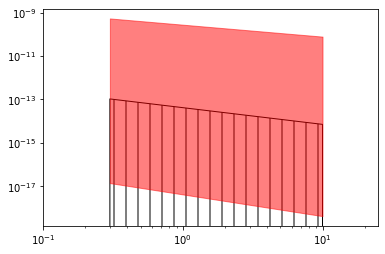

In [13]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma+Gammapos-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma-Gammaneg-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="|")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-9,1e-7)
plt.yscale("log")
plt.xscale("log")

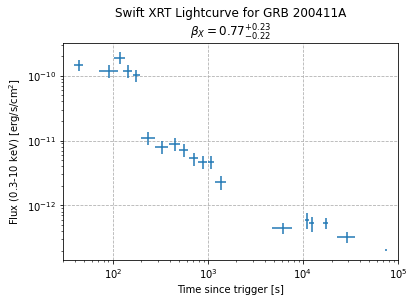

In [14]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X = %.2f_{-%.2f}^{+%.2f}$" % (burst,Gamma-1.,Gammaneg,Gammapos))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")
plt.xlim(3e1,1e5)
plt.show()

In [15]:
xrt_data = pd.DataFrame(columns=['Time', 'Tpos', 'Tneg', 'Flux', 'Fluxpos', 'Fluxneg', 'GRB'])
for i in new_sGRBs.index:
    GRB_ID = new_sGRBs.loc[i,"GRB"]
    
    try:
        (Gamma, Gammapos, Gammaneg) = get_BetaX(GRB_ID)
        fluxdata = XRT_lightcurve(GRB_ID)
        xrt_data = xrt_data.append(fluxdata,ignore_index=True)
        
        new_sGRBs.loc[i,"Beta_X"] = Gamma - 1
        new_sGRBs.loc[i,"Beta_X_neg"] = Gammaneg
        new_sGRBs.loc[i,"Beta_X_pos"] = Gammapos
        #print(f"Found {GRB_ID} at index {i}: {Gamma, Gammapos, Gammaneg}")
        
    except:
        print("Failed to retrieve",GRB_ID)

xrt_data

Failed to retrieve 190610A
Failed to retrieve 190427A
Failed to retrieve 190326A
Failed to retrieve 180718A
Failed to retrieve 180715A
Failed to retrieve 170325A
Failed to retrieve 170112A
Failed to retrieve 160726A
Failed to retrieve 160714A
Failed to retrieve 151228A
Failed to retrieve 151205B
Failed to retrieve 150710A


,Time,Tpos,Tneg,Flux,Fluxpos,Fluxneg,GRB
0,153.568,60.668,-62.190,9.118147e-12,2.043045e-12,-2.043045e-12,201006A
1,283.514,106.234,-69.278,4.848109e-12,1.258619e-12,-1.258619e-12,201006A
2,453.501,116.774,-63.753,4.677487e-12,1.215431e-12,-1.215431e-12,201006A
3,688.759,99.652,-118.485,3.889644e-12,1.010712e-12,-1.010712e-12,201006A
4,890.072,161.607,-101.661,3.182172e-12,8.314264e-13,-8.314264e-13,201006A
...,...,...,...,...,...,...,...
463,852.395,93.831,-94.217,4.259266e-12,1.055282e-12,-1.055282e-12,150423A
464,1027.645,146.741,-81.419,3.062173e-12,8.171559e-13,-8.171559e-13,150423A
465,4742.155,480.662,-311.650,9.861626e-13,2.640906e-13,-2.640906e-13,150423A
466,5872.965,1047.289,-650.147,4.524549e-13,1.236726e-13,-1.236726e-13,150423A


## Converting x-ray flux values to spectral flux densities

$$ F_\text{x} = \int_{0.3\text{ keV}}^{10\text{ keV}} F(E)\ dE = \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} F_\nu\ d\nu = A \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} \nu^{-\beta}\ d\nu $$
$$ F_\text{x} = \left.\begin{cases} A\frac{\nu^{1-\beta}}{1-\beta}, & \beta \neq 1 \\ A\ln(\nu), & \beta = 1 \end{cases}\right\}_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} $$

In [16]:
for i in xrt_data.index:
    grb_id = xrt_data.loc[i,"GRB"]
    beta = float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X"])
    beta_max = beta - float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X_pos"])
    beta_min = beta - float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X_neg"])
    Fx = xrt_data.loc[i,"Flux"]
    Fx_max = Fx + xrt_data.loc[i,"Fluxpos"]
    Fx_min = Fx + xrt_data.loc[i,"Fluxneg"]
    if beta == 1:
        integral = np.log(2.418e18) - np.log(7.254e16)
    else:
        integral = ((2.418e18)**(1-beta))/(1-beta) - ((7.254e16)**(1-beta))/(1-beta)
    A = Fx/integral
    log_mean_freq = 10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18
    spectral_flux = A*log_mean_freq**(-beta) # should be erg/s/cm^2/Hz (?)
    spectral_flux *= 1e23
    xrt_data.loc[i,"SpecFlux"] = spectral_flux    

## Correcting for extinction

$ A_b = R_b \cdot E_{B-V} $ for an arbitrary band $b$

In [17]:
RbTable = pd.read_csv("./Required Files/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"]) # function that takes a wavelength [Ang] and returns the corresponding R_b value

In [18]:
for i in new_optical.index:    
    try:
        new_optical.loc[i,"Extinction"] = Rb(new_optical.loc[i,"λ_eff"])*new_optical.loc[i,"E(B-V)"]
    except ValueError:
        pass

## Converting optical magnitudes to spectral flux densities

In [19]:
new_optical["Flux (Jy)"] = 3631*10**((new_optical["Magnitude"]-new_optical["Extinction"])/-2.5) # AB mag = 0 at F_nu = 3631 Jy

## Putting it all together

In [20]:
#testcase = calc_code.GRB(burst, )
new_optical[~new_optical["Flux (Jy)"].isna()]

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,Flux (Jy)
0,201006A,998907,Swift,UVOT,white_FC,3885.68,163.000,21.1,3-sigma,GCN 28565,1.27,5.059997,0.00139324
1,201006A,998907,Swift,UVOT,u_FC,3520.95,424.500,20.2,3-sigma,GCN 28565,1.27,5.455399,0.00459395
2,201006A,998907,Swift,UVOT,white,3885.68,813.500,21,3-sigma,GCN 28565,1.27,5.059997,0.00152765
3,201006A,998907,Swift,UVOT,v,5411.43,1026.000,18.9,3-sigma,GCN 28565,1.27,3.493137,0.00249621
4,201006A,998907,Swift,UVOT,b,4346.25,1038.000,19.8,3-sigma,GCN 28565,1.27,4.587303,0.00298502
...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,150423A,638808,Okayama,MITSuME,Ic,7845.53,42428.448,19.9,3-sigma,GCN 17742,0.03,0.047141,4.15798e-05
592,150423A,638808,La Palma,William Herschel Telescope/ACAM,g,4762.28,56822.000,25.3,5-sigma,GCN 17747,0.03,0.097992,3.01455e-07
597,150423A,638808,Akeno,MITSuME,g',4727.80,23744.000,19.4,UL,GCN 17763,0.03,0.098823,6.91123e-05
598,150423A,638808,Akeno,MITSuME,Rc,6479.38,23744.000,19.3,UL,GCN 17763,0.03,0.064233,7.34039e-05


In [21]:
max_dt = 0.1
nu_x = 10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18
results = pd.DataFrame(columns=["GRB","dt%","nu_o","F_o","nu_x","F_x","B_ox"])
for i_o in new_optical.index:
    t_o = float(new_optical.loc[i_o,"Time (s)"])
    F_o = float(new_optical.loc[i_o,"Flux (Jy)"])
    nu_o = 299792458/float(new_optical.loc[i_o,"λ_eff"]/1e10)
    for i_x in xrt_data.index:
        t_x = float(xrt_data.loc[i_x,"Time"])
        dt = np.abs(t_o-t_x)/t_o
        if dt > max_dt or new_optical.loc[i_o,"GRB"] != xrt_data.loc[i_x,"GRB"]:
            pass
        else:
            F_x = float(xrt_data.loc[i_x,"SpecFlux"])
            Beta_ox = -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)
            if not np.isnan(Beta_ox):
                results = results.append({"GRB":new_optical.loc[i_o,"GRB"], "dt%":dt,
                       "nu_o":nu_o, "F_o":F_o, "nu_x":nu_x, "F_x":F_x,
                       "B_ox":Beta_ox},ignore_index=True)

# get the previously retreived x-ray spectral indices for comparison
for i in results.index:
    grb_id = results.loc[i,"GRB"]
    results.loc[i,"B_x"] = float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X"])

In [30]:
print("Jakobsson",results.loc[results["B_ox"]<0.5,"GRB"].unique())
print("van der Horst",results.loc[results["B_ox"]<results["B_x"]-0.5,"GRB"].unique())

Jakobsson ['200411A' '191031D' '181123B' '180727A' '180204A' '160927A' '160821B'
 '160624A' '151229A' '150831A']
van der Horst ['200411A' '181123B' '180204A' '160821B' '160624A' '151229A' '150831A']


In [26]:
def simulate_spectrum(idx):
    inter_freqs = np.linspace(results.loc[idx,"nu_o"],0.3/4.135667696e-18,100)
    xray_freqs = np.linspace(0.3,10,100)/4.135667696e-18
    
    ox_spec = inter_freqs**(-results.loc[idx,"B_ox"])
    ox_spec *= (results.loc[idx,"F_o"]/ox_spec[0])
    x_spec = xray_freqs**(-results.loc[idx,"B_x"])
    x_spec *= (ox_spec[-1]/x_spec[0])
    plt.plot(inter_freqs,ox_spec,label=r"$\beta_{ox}=%f$"%(-results.loc[idx,"B_ox"]))
    plt.plot(xray_freqs,x_spec,label=r"$\beta_x=%f$"%(-results.loc[idx,"B_x"]))
    plt.vlines([10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18],0,10**np.log10((x_spec.max()+x_spec.min())/2),"k",linestyle="--")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    #plt.gca().set_yticklabels([])
    plt.show()

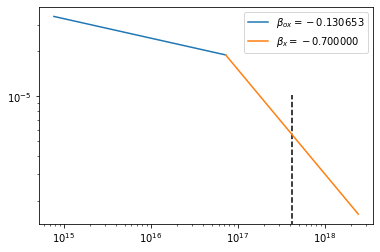

In [27]:
simulate_spectrum(82)